# Analyse the Grid Search model fitting

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import chi2 as chi2_distribution
from scipy.special import gammaincc
from typing import Iterable

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

##### Some handy functions

In [2]:
def extract_vsini(vsini:str)->int:
    """
    Takes a string like 'vsini###'
    This function extracts the number

    Args:
        vsini (str): String like 'vsini###'

    Returns:
        int: The number in the string
    """
    return int(re.search(r'\d+$', vsini).group())


def object_name_to_save_name(input_string):
    # Replace every '-' with '_'
    modified_string = input_string.replace('-', '_')
    
    # Remove space before capital 'X'
    modified_string = modified_string.replace(' ', '')

    return modified_string

##### Import the data

In [3]:
# Define the path to the gridsearch_info.txt file
file_path = '/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject/ModelFitting/FitResults/4U1538_52S100E250delta5/gridsearch_info.txt'
# Initialize variables to store extracted information
grid_search_info = {}

# Open the file and read its contents
with open(file_path, 'r') as file:
    scentences = file.readlines()

    # Iterate through each line in the file
    for line in scentences:
        # Split the line based on the tab character ('\t') or any other delimiter used
        parts = line.split('\t')

        # Extract information based on the structure of the file
        if parts[0] == 'Object: ':
            grid_search_info['Object'] = parts[2].strip()
            object_name = parts[2].strip()
        elif parts[0] == 'FolderPath: ':
            grid_search_info['FolderPath'] = parts[1].strip()
            folder_path = parts[1].strip()
        elif parts[0] == 'Galaxy: ':
            grid_search_info['Galaxy'] = parts[2].strip()
            galaxy = parts[2].strip()
        elif parts[0] == 'Radial Velocity: ':
            grid_search_info['vrad'] = parts[2].strip()
            vrad = round(float(parts[2].strip()), 3)
        elif parts[0] == 'Radial Velocity error: ':
            grid_search_info['vrad_err'] = parts[1].strip()
            vrad_err = round(float(parts[1].strip()), 3)
        # Add more conditions to extract other information as needed

# Change the object name to save name
object_ = object_name_to_save_name(object_name)

# Now, you have extracted information stored in the grid_search_info dictionary
# You can access it like this:
print("Object:", grid_search_info.get('Object', 'Not Found'))
print("Object_:", object_)
print("FolderPath:", grid_search_info.get('FolderPath', 'Not Found'))
print("Galaxy:", grid_search_info.get('Galaxy', 'Not Found'))
print("Radial velocity:", grid_search_info.get('vrad', 'Not Found'), ' km/s')
print("Radial velocity error:", grid_search_info.get('vrad_err', 'Not Found'), ' km/s') 
print(f'vrad = {vrad} +- {vrad_err} km/s')

Object: 4U1538-52
Object_: 4U1538_52
FolderPath: /mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject/ModelFitting/FitResults/4U1538_52S100E250delta5/
Galaxy: Milkyway
Radial velocity: -166.2300897421131  km/s
Radial velocity error: 11.748865314523458  km/s
vrad = -166.23 +- 11.749 km/s


In [4]:
# Load the JSON file
with open(folder_path + 'Chi2.json', 'r') as json_file:
    grid_result = json.load(json_file)

# Load the JSON file
with open(folder_path + 'Chi2_perline.json', 'r') as json_file:
    grid_result_perline = json.load(json_file)

- Take the minimun $\chi^{2}$ value for every value of vsin(i):  <strong> min_chi2_list </strong>
- Save every vsin(i): <strong> vsini_list </strong>
- For every vsin(i) save the name of the best model: <strong> best_models </strong>

In [5]:
vsini_list = []
min_chi2_list = []
best_models = []

for vsini, chi2 in grid_result.items():
    vsini_list.append(extract_vsini(vsini))
    min_chi2_list.append(chi2[min(chi2, key=chi2.get)])
    best_models.append(min(chi2, key=chi2.get))

##### First result

In [6]:
# Best vsin(i)
vsini_best = list(grid_result.keys())[min_chi2_list.index(min(min_chi2_list))]

# All chi2 values of the best vsin(i)
chi2_best = grid_result[vsini_best]

# Best model of the best vsin(i)
best_model = min(chi2_best, key=chi2_best.get)

print(f"The minimum chi-squared: \t {round(chi2_best[min(chi2_best, key=chi2_best.get)], 4)}")
print(f"The best vsin(i): \t\t {extract_vsini(vsini_best)} km/s")
print(f"This is for model: \t\t {best_model}")

The minimum chi-squared: 	 4.4349
The best vsin(i): 		 160 km/s
This is for model: 		 T16000logg2.0


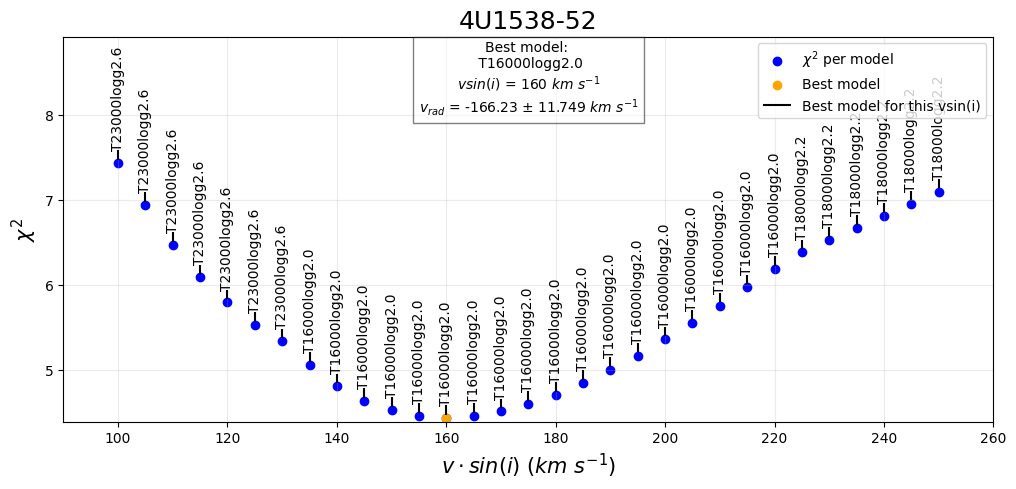

In [7]:
plt.figure(figsize=(12,5))
plt.scatter(vsini_list, min_chi2_list, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.89, f'Best model: \n {best_model}\n' + r'$vsin(i)$ = ' + f'{extract_vsini(vsini_best)} ' + r'$km$ $s^{-1}$' + '\n' + 
         r'$v_{rad}$ = ' + f'{vrad}' + r' $\pm$ ' + f'{vrad_err}' + r' $km$ $s^{-1}$', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Annotate each line with text vertically
plt.vlines(vsini_list, 
           ymin=np.array(min_chi2_list) + max(min_chi2_list) / 200, 
           ymax=np.array(min_chi2_list) + max(min_chi2_list) / 50, 
           color='black', label='Best model for this vsin(i)')

for (x, y, best_model_) in zip(vsini_list, min_chi2_list, best_models):
    plt.text(x, y + max(min_chi2_list) / 50, 
             f'{best_model_}', ha='center', va='bottom', rotation=90, size=10)

plt.title(f"{object_name}", fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.2)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

##### How does the $\chi^{2}$ distribution look for just the best model

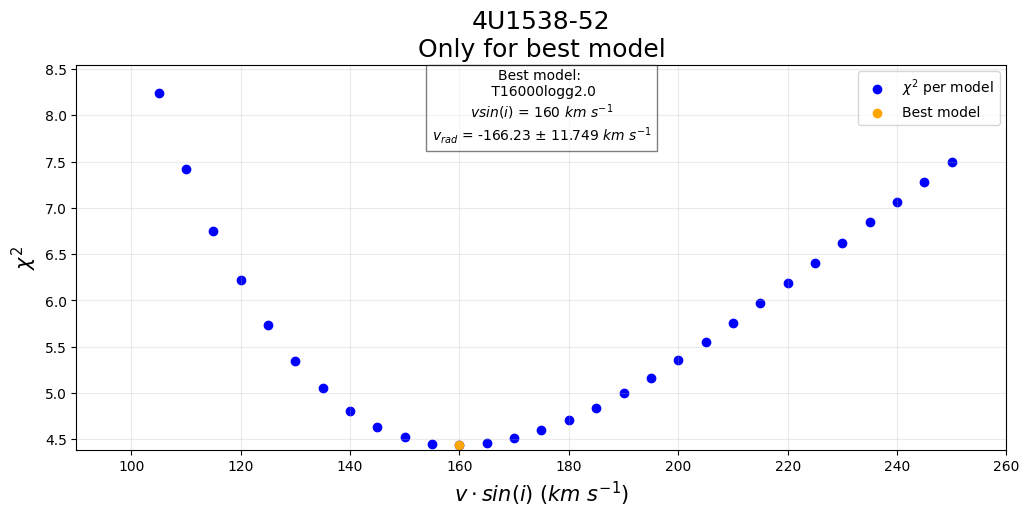

In [8]:
vsini_list_best = []
min_chi2_list_best = []

for vsini, chi2 in grid_result.items():
    vsini_list_best.append(extract_vsini(vsini))
    min_chi2_list_best.append(chi2[best_model])

plt.figure(figsize=(12,5))
plt.scatter(vsini_list_best, min_chi2_list_best, color='blue', label=r'$\chi^{2}$ per model')
plt.scatter(extract_vsini(vsini_best), chi2_best[best_model], color='orange', label='Best model')

plt.text(0.5, 0.89, f'Best model: \n {best_model}\n' + r'$vsin(i)$ = ' + f'{extract_vsini(vsini_best)} ' + r'$km$ $s^{-1}$' + '\n' + 
         r'$v_{rad}$ = ' + f'{vrad}' + r' $\pm$ ' + f'{vrad_err}' + r' $km$ $s^{-1}$',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"{object_name}\nOnly for best model" , fontsize=18)
plt.ylabel(r'$\chi^{2}$', fontsize=15)
plt.xlabel(r'$v \cdot sin(i)$ ($km$ $s^{-1}$)', fontsize=15)

plt.xlim(min(vsini_list) - 10, max(vsini_list) + 10)
plt.ylim(min(min_chi2_list) * 0.99, max(min_chi2_list) * 1.15)

plt.grid(alpha=0.25)
plt.legend(loc='best')

# plt.savefig("../Plots/GridSearchAnalysisCenX_3.png")

plt.show()

##### Plot the best model of the spectral lines

0 1
0 2
0 3
1 0
1 1
1 2
1 3


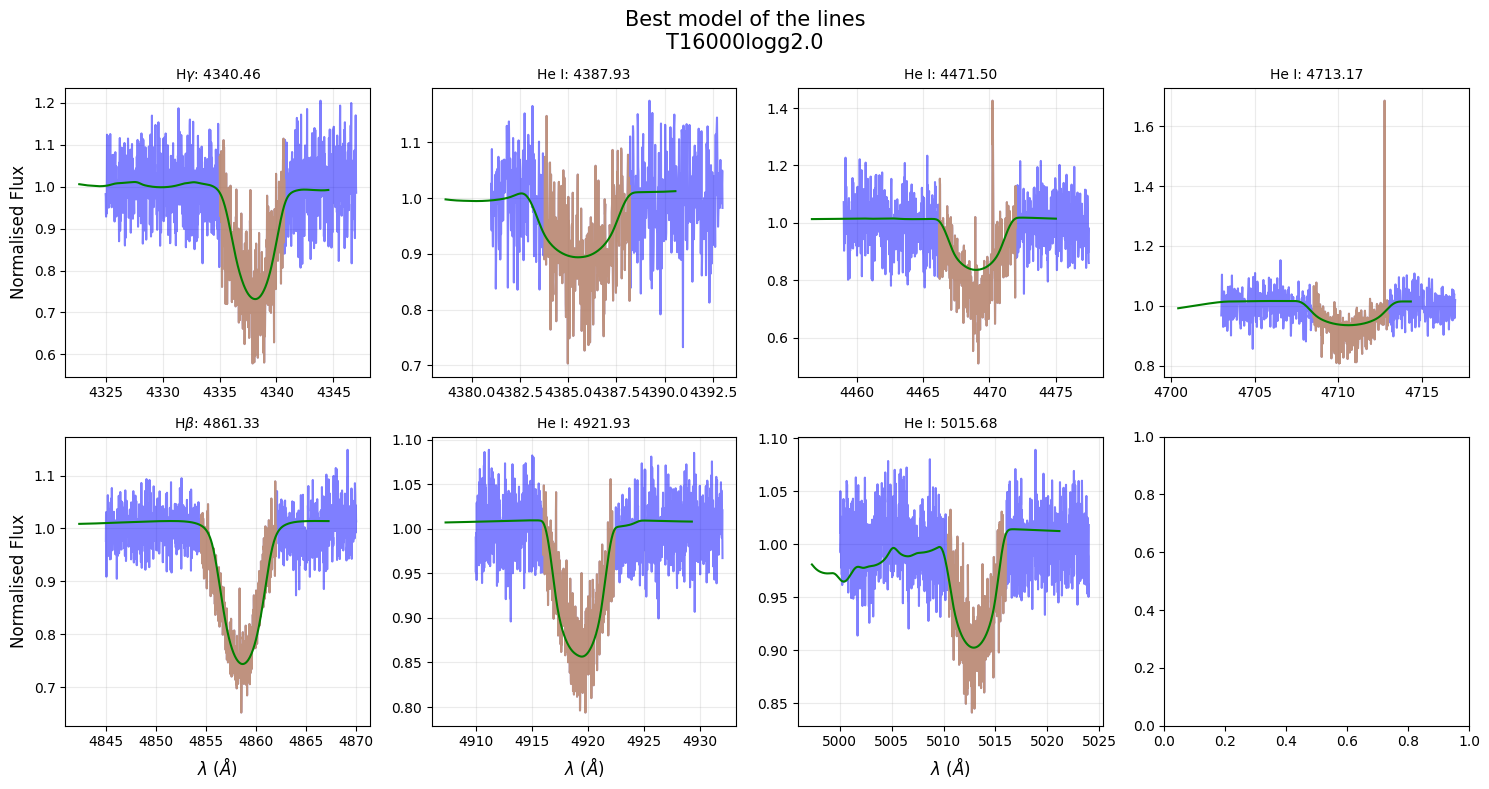

In [9]:
spectra = import_spectra(object_)
models = import_models_quickload(galaxy)
spectral_lines = lines(object_name)

plot_best_model(spectra, models, spectral_lines, best_model, vrad, extract_vsini(vsini_best))

#### Plot the $\chi^{2}$ values per parameter.

Get all $\frac{1}{\chi^{2}}$ values per parameter

In [10]:
# Lists to save model parameter values
Teff_list = []
logg_list = []
vsini_list = []

# Lists to save chi-squared values
chi2_Teff = []
chi2_logg = []
chi2_vsini = []

for vsini, chi2 in grid_result.items():
    # Get the vsini value in km/s
    vsini_value = extract_vsini(vsini)

    for model_name, chi2_model in chi2.items():
        Teff, logg = extract_temperature_and_gravity(model_name)

        # Save parameters
        Teff_list.append(Teff)
        logg_list.append(logg)
        vsini_list.append(vsini_value)

        # Save inverse chi-squared values
        chi2_Teff.append(1 / chi2_model)
        chi2_logg.append(1 / chi2_model)
        chi2_vsini.append(1 /chi2_model)

In [11]:
np.argmax(chi2_Teff)
Teff_list[np.argmax(chi2_Teff)]

16000

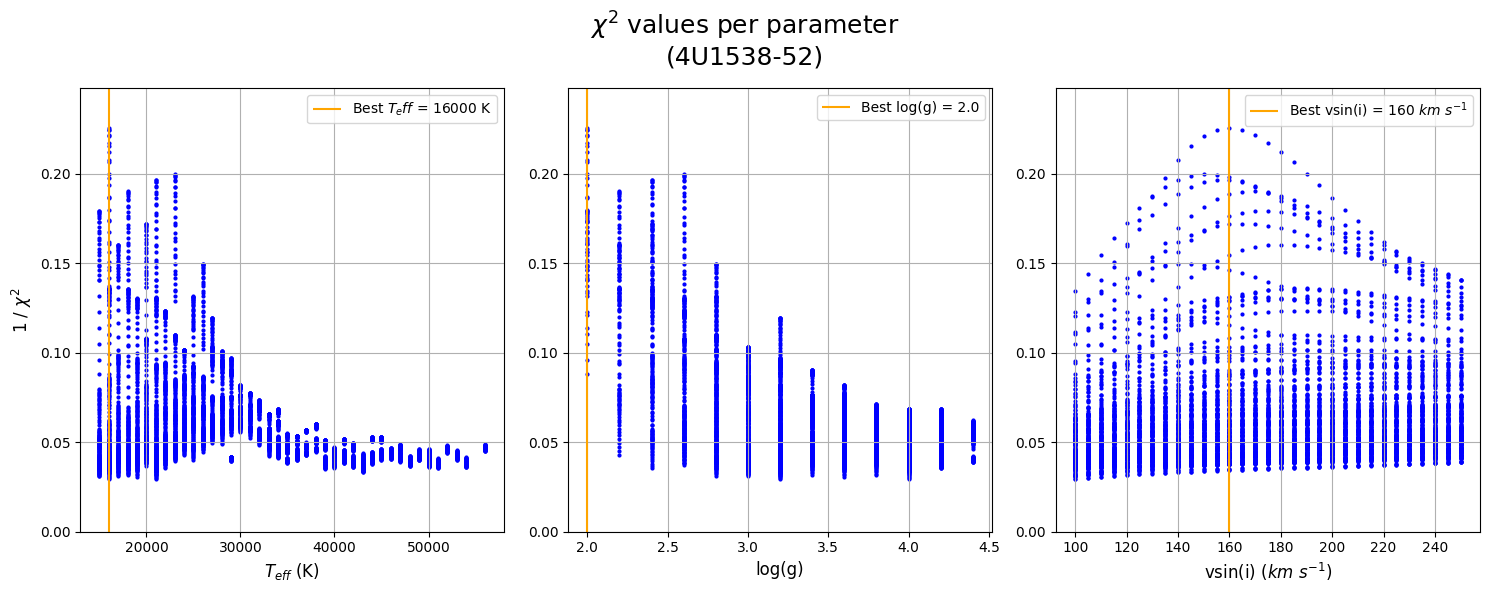

In [12]:
fig, axes = plt.subplots(1,3, figsize=(15,6))

axes[0].scatter(Teff_list, chi2_Teff, s=4, color='blue')
axes[0].vlines(Teff_list[np.argmax(chi2_Teff)], ymin=0, ymax=max(chi2_Teff)*1.1, 
               color='orange', label=r'Best $T_eff$ = ' + f'{Teff_list[np.argmax(chi2_Teff)]} K')
axes[0].set_ylabel(r'1 / $\chi^{2}$', fontsize=12)
axes[0].set_xlabel(r'$T_{eff}$ (K)', fontsize=12)

axes[1].scatter(logg_list, chi2_logg, s=4, color='blue')
axes[1].vlines(logg_list[np.argmax(chi2_logg)], ymin=0, ymax=max(chi2_logg)*1.1, 
               color='orange', label=r'Best log(g) = ' + f'{logg_list[np.argmax(chi2_logg)]}')
axes[1].set_xlabel(r'log(g)', fontsize=12)

axes[2].scatter(vsini_list, chi2_vsini, s=4, color='blue')
axes[2].vlines(vsini_list[np.argmax(chi2_vsini)], ymin=0, ymax=max(chi2_vsini)*1.1, 
               color='orange', label=r'Best vsin(i) = ' + f'{vsini_list[np.argmax(chi2_vsini)]} ' + r'$km$ $s^{-1}$')
axes[2].set_xlabel(r'vsin(i) ($km$ $s^{-1}$)', fontsize=12)

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_ylim(bottom=0, top=max(chi2_vsini)*1.1)

plt.suptitle(r'$\chi^{2}$ values per parameter' + f'\n({object_name})', fontsize=18)
plt.tight_layout()
plt.show()

#### Determining the 1 $\sigma$ confidence intervals

In [13]:
# Lists to save model parameter values
Teff_list = []
logg_list = []
vsini_list = []

# Lists to save chi-squared values
chi2_Teff = []
chi2_logg = []
chi2_vsini = []

for vsini, chi2 in grid_result.items():
    # Get the vsini value in km/s
    vsini_value = extract_vsini(vsini)

    for model_name, chi2_model in chi2.items():
        Teff, logg = extract_temperature_and_gravity(model_name)

        # Save parameters
        Teff_list.append(Teff)
        logg_list.append(logg)
        vsini_list.append(vsini_value)

        # Save inverse chi-squared values
        chi2_Teff.append(chi2_model)
        chi2_logg.append(chi2_model)
        chi2_vsini.append(chi2_model)

# Degrees of freedom
degrees_of_freedom = 20

# Normalise the chi-squared values.
chi2_Teff = np.array(chi2_Teff) / min(chi2_Teff)
chi2_logg = np.array(chi2_logg) / min(chi2_logg)
chi2_vsini = np.array(chi2_vsini) / min(chi2_vsini)

In [14]:
def calculate_probability(chi2_value, degrees_of_freedom):
    return 1 - gammaincc(chi2_value/2, degrees_of_freedom/2)

for i, chi2_value in enumerate(chi2_Teff):
    probability = calculate_probability(chi2_value, degrees_of_freedom)
    if probability >= 0.05:
        True